In [47]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display

In [48]:
''' Load image using OpenCV '''
# Upload the LMS image to Google Drive and point to its location.
# Note OpenCV reads image as BGR.
image_directory = '/home/phw93/dev/calib/data/*.jpg'
# image_directory = '/home/phw/dev/calib/data/*.jpg'
image_files = glob.glob(image_directory)
image_files = sorted(image_files)
images = []
gray_images = []
for image_file in image_files:
    image = cv2.imread(image_file)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    images.append(image)
    gray_images.append(gray_image)
    
images_len = len(gray_images)
# Normalize image to between 0 and 1.

checkboard = [8,6]


Width, Height:  1280 720
Image len:  1842
Checker board size:  8 6
float32
0.003921569 1.0


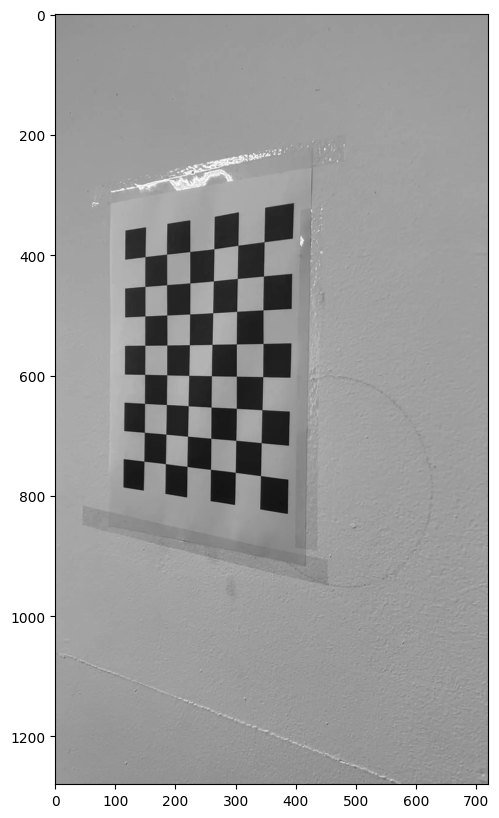

In [49]:
# Show output
w, h = gray_images[2].shape
print("Width, Height: ",w, h)
print("Image len: ", images_len)
print("Checker board size: ",checkboard[0], checkboard[1])

print(gray_images[0].dtype)
print(np.min(gray_images[0]), np.max(gray_images[0]))
plt.figure(figsize=(10, 10))
plt.imshow(gray_images[5], cmap='gray')
plt.show()

In [50]:
# # Perform Sobel filtering along the x-axis, y-axis.
# arrIx = []
# arrIy = []
# sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
# sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# for gray_image in gray_images:
#     Ix = cv2.filter2D(gray_image, -1, sobel_x)
#     Iy = cv2.filter2D(gray_image, -1, sobel_y)
#     arrIx.append(Ix)
#     arrIy.append(Iy)

# print(len(arrIx))    

In [51]:
# plt.imshow(arrIx[111], cmap='gray')
# plt.imshow(arrIy[111], cmap='gray')

In [52]:
# extract corner & NMS
arrCorners = []

window_size = 3
half_size = window_size // 2
winSize = (window_size*2+1, window_size*2+1)
zeroZone = (-1, -1)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
for gray_image in gray_images:
    max_corners = 100   # 최대 코너 개수
    quality_level = 0.01  # 코너 품질 임계값 (0 ~ 1 사이의 값)
    min_distance = 10  # 검출된 코너 간의 최소 거리
    mask = np.empty((0, 0), dtype=np.float32)
    corners = cv2.goodFeaturesToTrack(gray_image, max_corners, quality_level, min_distance, mask, blockSize=3, useHarrisDetector=True, k=0.04)
    cv2.cornerSubPix(gray_image, corners, winSize, zeroZone, criteria)
    arrCorners.append(corners)
    
# for corners in arrCorners:
#     print(len(corners))

In [70]:
# draw corners
filtImg = []
filtCorners = []
for image, corners in zip(images, arrCorners):
    if(len(corners)>=(checkboard[0] * checkboard[1] + 3 * (checkboard[0] + checkboard[1]))):
        continue    
    temp = image.copy()
    mean = np.mean(corners, axis=0)
    variance = np.var(corners, axis=0)
    # 분산을 기준으로 일정 이내에 있는 포인트들 필터링
    threshold = 1.3  # 일정 분산 임계값 (조정 가능)
    filtered_points = []
    for corner in corners:
        if np.all(np.abs(corner - mean) <= threshold * np.sqrt(variance)):
            filtered_points.append(corner)
            x, y = corner[0, 0].astype(int), corner[0, 1].astype(int)
            cv2.drawMarker(temp, (x, y), color=(0, 0, 255), markerType=cv2.MARKER_STAR, markerSize=10, thickness=3)
    if(len(filtered_points) > checkboard[0]*checkboard[1]-1):
        filtCorners.append(filtered_points)
        filtImg.append(temp)

152
56
[[array([[227.91125, 614.89795]], dtype=float32), array([[228.93741, 673.21783]], dtype=float32), array([[345.875  , 845.78015]], dtype=float32), array([[407.95297, 557.8029 ]], dtype=float32), array([[287.55197, 615.8759 ]], dtype=float32), array([[229.70276, 730.26636]], dtype=float32), array([[287.95276, 674.12427]], dtype=float32), array([[407.172  , 617.67975]], dtype=float32), array([[404.71716, 792.0764 ]], dtype=float32), array([[520.7859, 908.9303]], dtype=float32), array([[225.95958, 494.60632]], dtype=float32), array([[346.95667, 674.9733 ]], dtype=float32), array([[226.93845, 555.5506 ]], dtype=float32), array([[467.69843, 619.04333]], dtype=float32), array([[408.99557, 496.3963 ]], dtype=float32), array([[230.76859, 842.2364 ]], dtype=float32), array([[287.1362, 556.5479]], dtype=float32), array([[230.25542, 786.7272 ]], dtype=float32), array([[288.25754, 731.0653 ]], dtype=float32), array([[461.7026 , 905.61285]], dtype=float32), array([[404.16898, 848.3727 ]], dty

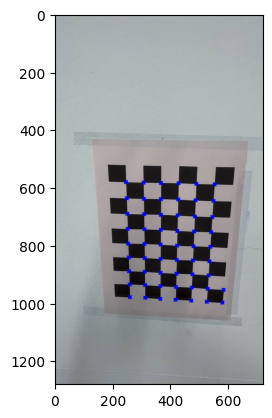

In [76]:
# 이미지 표시
n = 60
plt.imshow(filtImg[n], cmap='gray')
print(len(filtCorners))
print(len(filtCorners[n]))
print(filtCorners)

In [ ]:
def find_homography_ransac(points_dict, num_iterations=1000, inlier_threshold=5):
    # Convert dictionary values to arrays
    src_pts = np.array([key for key in points_dict.keys()])
    dst_pts = np.array([value for value in points_dict.values()])
    best_inliers = []
    best_homography = None
    for i in range(num_iterations):
        # Randomly select 4 point correspondences
        indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[indices]
        dst_sample = dst_pts[indices]
        # Compute the homography matrix using the 4 correspondences
        homography = compute_homography(src_sample, dst_sample)
        # Apply the homography to all source points
        transformed_pts = apply_homography(src_pts, homography)
        # Calculate Euclidean distance between transformed points and destination points
        errors = np.linalg.norm(transformed_pts - dst_pts, axis=1)
        # Count inliers within the threshold
        inliers = np.where(errors < inlier_threshold)[0]
        # Update best inliers and homography if the current set has more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_homography = compute_homography(src_pts[inliers], dst_pts[inliers])
    return best_homography
def compute_homography(src_pts, dst_pts):
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    homography = V[-1].reshape(3, 3)
    homography /= homography[2, 2]
    return homography
def apply_homography(src_pts, homography):
    src_pts = np.concatenate((src_pts, np.ones((len(src_pts), 1))), axis=1)
    transformed_pts = np.dot(homography, src_pts.T).T
    transformed_pts /= transformed_pts[:, 2][:, np.newaxis]
    return transformed_pts[:, :2]
# 예시 입력 데이터 (points_dict)
points_dict = {
    (141, 131): (318, 256),
    (480, 159): (534, 372),
    (493, 630): (316, 670),
    (64, 601): (73, 473)
}
homography_matrix = find_homography_ransac(points_dict)
print(homography_matrix)